## Annotation analisys (labelling)

This notebook is an attempt to compute dynamic statistics of the dataset tags and labels.

In [29]:
import os
from difflib import SequenceMatcher
from pathlib import Path

from bs4 import BeautifulSoup, NavigableString, Tag

In [30]:
from typing import Union, List


def get_nodes(soup) -> Union[List, List[List]]:
    tags_text = []

    paragraph_tag = "p"

    for child in soup.tei.children:
        if child.name == 'text':
            tags_text.extend([paragraph for paragraph in child.find_all(paragraph_tag)])
            # tags_captions.extend([paragraph for paragraph in child.find_all("ab")])

    return tags_text


def process_dir(input):
    accumulated_statistics = []
    for root, dirs, files in os.walk(input):
        for file_ in files:
            if not file_.lower().endswith(".xml"):
                continue
            abs_path = os.path.join(root, file_)
            # print("Processing: " + str(abs_path))
            output_data = process_file(abs_path)
            accumulated_statistics.append(output_data)

    return accumulated_statistics


def process_file(input):
    with open(input, encoding='utf-8') as fp:
        doc = fp.read()

    soup = BeautifulSoup(doc, 'xml')

    entities_statistics = {}
    document_statistics = {
        'name': Path(input).name,
        'path': str(Path(input).absolute()),
        'paragraphs': 0,
        'entity_no_type': 0,
        'entities': 0,
        'uniq_entities': 0,
        'classes': 0,
        'sub_classes': 0,
        'entities_statistics': entities_statistics
    }
    
    paragraphs = get_nodes(soup)
    
    for paragraph in paragraphs:
        document_statistics['paragraphs'] += 1
        j = 0
        paragraphText = ''
        for item in paragraph.contents:
            if type(item) == NavigableString:
                paragraphText += str(item)

            elif type(item) is Tag and item.name == 'rs':
                paragraphText += item.text
                document_statistics['entities'] += 1
                tag_content = item.text
                paragraphText += str(item.text)
                tag_name = None
                if 'type' not in item.attrs:
                    document_statistics['entity_no_type'] += 1
                else:
                    tag_name = item.attrs['type']

                if 'subtype' in item.attrs:
                    tag_name = f"{tag_name}/{item.attrs['subtype']}"

                if tag_name not in entities_statistics:
                    entities_statistics[tag_name] = {
                        'count': 1,
                        'content_distribution': {
                            tag_content: 1
                        }
                    }
                else:
                    content_ = entities_statistics[tag_name]
                    content_['count'] += 1
                    if tag_content not in content_['content_distribution']:
                        content_['content_distribution'][tag_content] = 1
                    else:
                        content_['content_distribution'][tag_content] += 1

            document_statistics['classes'] = len(set(entities_statistics.keys()))

    uniq_entities = 0
    for key in entities_statistics:
        uniq_entities += len(entities_statistics[key]['content_distribution'])

    document_statistics['uniq_entities'] = uniq_entities

    ## Cross-checks

    # Verify that the sum of the content distribution corresponds to the tag distribution
    total_entities = 0
    for tag in entities_statistics:
        count = entities_statistics[tag]['count']
        sum_content_distributions = 0
        content_distribution_dict = entities_statistics[tag]['content_distribution']
        for content in content_distribution_dict:
            sum_content_distributions += content_distribution_dict[content]

        assert "Number of total entities per tag does not correspond to the sum.", count == sum_content_distributions
        total_entities += count

    assert "Number of total entities per documnent does not correspond to the sum.", total_entities == document_statistics['entities']

    return document_statistics


def group_by_with_soft_matching(input_list, threshold):
    matching = {}
    last_matching = -1

    for index_x, x in enumerate(input_list):
        unpacked = [y for x in matching for y in matching[x]]
        if x not in matching and x not in unpacked:
            matching[x] = []

            for index_y, y in enumerate(input_list[index_x + 1:]):
                if x == y:
                    continue

                if SequenceMatcher(None, x.lower(), y.lower()).ratio() > threshold:
                    matching[x].append(y)

        else:
            continue

    return matching


def aggregate(entities_statistics, threshold):
    """
    Aggregate the statistics by merging content belonging to the same entity:
     - variation of expressions (e.g. cuprates, cuprate, Cuprates, ...)
     - synonyms (e.g. 111, cuprates, ...)

    :param document_statistics:
    :param threshold:
    :return: an aggregated statistics for documents
    """

    agg = {}

    for tag in entities_statistics:
        if tag == 'tcValue' or tag == 'pressure':
            continue

        distribution = entities_statistics[tag]["content_distribution"]

        content_list = sorted(distribution.keys())
        # hash_list = []
        # for content in content_list:
        #     hash_value = content.lower().replace(" ", "")
        #     hash_list.append((hash_value, content))

        aggregated = group_by_with_soft_matching(content_list, threshold)

        agg[tag] = aggregated

        assert "Total number of element does not corresponds with the aggregated ones", len(content_list) == (
                len(agg.keys()) + len([y for x in aggregated for y in aggregated[x]]))

    return agg


def extract_csv(output_data):
    entity_statistics = output_data['entities_statistics']
    csv_rows = []
    for tag in entity_statistics:
        for content in entity_statistics[tag]['content_distribution']:
            row = [tag, content, entity_statistics[tag]['content_distribution'][content]]
            csv_rows.append(row)

    return csv_rows


def intersection(lst1, lst2):
    # Use of hybrid method
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3


def extract_inconsistencies(output_data, ignore_comparisons={}):
    entity_statistics = output_data['entities_statistics']
    summary_content = {}
    for tag in entity_statistics:
        for content in entity_statistics[tag]['content_distribution']:
            if tag in summary_content:
                summary_content[tag].append(content)
            else:
                summary_content[tag] = [content]

    inconsistencies = []

    tags = list(summary_content.keys())
    for id1 in range(0, len(tags)):
        for id2 in range(id1 + 1, len(tags)):
            tag1 = tags[id1]
            tag2 = tags[id2]

            if tag1 in ignore_comparisons.keys():
                if tag2 == ignore_comparisons[tag1]:
                    continue
            elif tag2 in ignore_comparisons.keys():
                if tag1 == ignore_comparisons[tag2]:
                    continue

            tag1_content = summary_content[tag1]
            tag2_content = summary_content[tag2]

            intersected_content = intersection(tag1_content, tag2_content)

            if len(intersected_content) > 0:
                for intersected_content_ in intersected_content:
                    frequency1 = entity_statistics[tag1]['content_distribution'][intersected_content_]
                    frequency2 = entity_statistics[tag2]['content_distribution'][intersected_content_]
                    intersected_tags = [(tag1, frequency1), (tag2, frequency2)]
                    inconsistencies.append([intersected_content_, tag1, frequency1, tag2, frequency2])

    return inconsistencies

def find_longest_entities(output_data, topValues=10): 
    print(output_data)


Analysis 

In [31]:
def run_analysis(input): 
    output_data = {}

    input_path = Path(input)
    documents_statistics = process_dir(input_path)

    aggregated_entities_statistics = {}
    output_data = {
        'path': str(Path(input_path).absolute()),
        'files': len(documents_statistics),
        'paragraphs': 0,
        'entities_no_type': 0,
        'entities': 0,
        'uniq_entities': 0,
        'classes': 0,
        'entities_statistics': aggregated_entities_statistics
    }

    classes = []

    ## Summary of all articles

    for document_statistics in documents_statistics:
        output_data['paragraphs'] += document_statistics['paragraphs']
        output_data['entities_no_type'] += document_statistics['entity_no_type']
        output_data['entities'] += document_statistics['entities']
        output_data['uniq_entities'] += document_statistics['uniq_entities']

        for tag in document_statistics['entities_statistics']:
            classes.append(tag)
            tag_statistics = document_statistics['entities_statistics'][tag]
            if tag not in aggregated_entities_statistics:
                aggregated_entities_statistics[tag] = tag_statistics
            else:
                count = tag_statistics['count']
                aggregated_entities_statistics[tag]['count'] += count

                dist = tag_statistics['content_distribution']
                aggregated_distribution = aggregated_entities_statistics[tag]['content_distribution']

                for content in dist:
                    if content not in aggregated_distribution:
                        aggregated_distribution[content] = dist[content]
                    else:
                        aggregated_distribution[content] += dist[content]

        output_data['classes'] = len(set(classes))

    output_data['documents'] = documents_statistics
    output_data['aggregated_statistics'] = aggregate(aggregated_entities_statistics, 0.90)
    
    #find_longest_entities(output_data)

    return output_data 

Run Analysis 

In [32]:
input = "../documents/tei-validated"
    
result = run_analysis(input)    

Extract summary on class repartition by frequency

In [33]:
columns=['files', 'paragraphs', 'entities_no_type', 'entities', 'uniq_entities', 'classes']
rows = [result[c] for c in columns]

import pandas as pd
pd.DataFrame([rows], columns=columns)

,files,paragraphs,entities_no_type,entities,uniq_entities,classes
0,300,17316,0,4756,2979,17


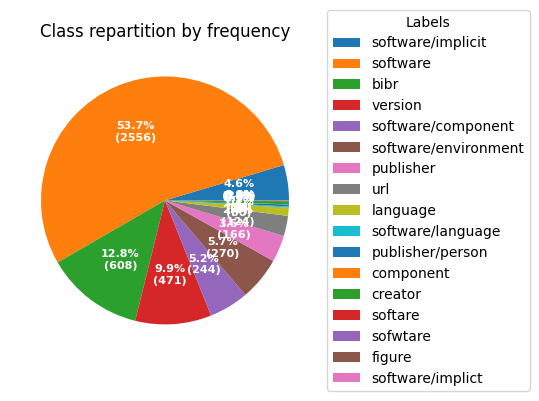

/var/folders/mk/scd8428n18jfgh3jdthbvpz00000gn/T/ipykernel_6702/436060154.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


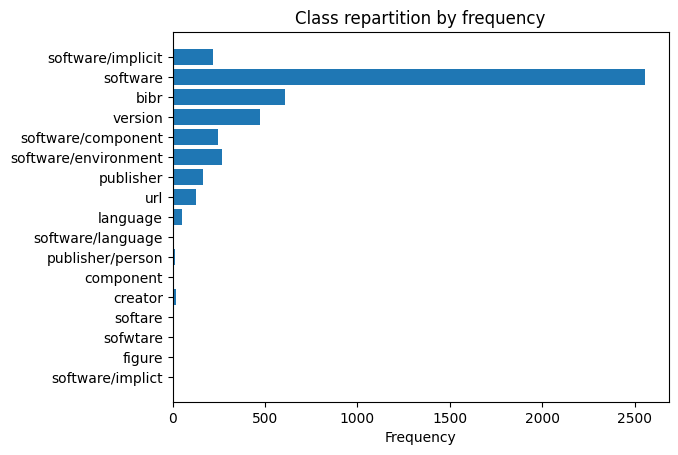

In [34]:
aggregated_statistics = result['aggregated_statistics']
entities_statistics = result['entities_statistics']

# print(json.dumps(entities_statistics, indent=4))

labels = []
values = []

for label in entities_statistics.keys(): 
    labels.append(label)
    values.append(entities_statistics[label]['count'])

    
## PIE
import matplotlib.pyplot as plt
import numpy as np

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
    

fig, ax = plt.subplots(figsize=(4, 8), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: func(pct, values),
                                  textprops=dict(color="w"))


ax.legend(wedges, labels,
          title="Labels",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Class repartition by frequency")
plt.show()

## HISTOGRAM

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(labels, values, align='center')
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Class repartition by frequency')

plt.show()

#csv_row = extract_csv(output_data)


# Inconsistencies 

In the following section we show annotations that have been annotated in different ways. 
For example if a certain name "xyz" has been annotated twice with two different annotations, it is listed under here. 


This doesn't means necessarly it's an error. We can conclude that the inconsistency tc-material can be attributed to mistakes, while material-class is due to ambiguities and overlapping in the definition of both labels where the outcome depends strongly from the context. 

In [35]:
result["inconsistencies"] = extract_inconsistencies(result, ignore_comparisons={"bibr": "version"})
inconsistent_classes = result["inconsistencies"]

# print(inconsistent_classes)

rows = inconsistent_classes
columns=['name', 'class 1', 'frequency', 'class 2', 'frequency']
    
import pandas as pd
pd.DataFrame(rows, columns=columns)

,name,class 1,frequency,class 2,frequency
0,script,software/implicit,9,software,1
1,tool,software/implicit,35,software,1
2,libraries,software/implicit,2,software/component,1
3,Rx,software,4,software/component,1
4,PythonTransform,software,1,software/component,1
...,...,...,...,...,...
122,IBM,publisher,2,creator,1
123,GraphPad,publisher,1,creator,1
124,StataCorp,publisher,2,creator,1
125,Kotlin,language,1,software/language,1


# Label summary

In this section we analise each label and we output 
 - top terms 
 - the aggregation of similar terms using soft-matching

In [36]:
def plot_top_10(label, statistics): 
    class_statistics = statistics[label]
    class_count = class_statistics['count']
    print("count: " + str(class_count))
    class_frequency = class_statistics['content_distribution']
           
    sorted_by_value = {k: v for k, v in sorted(class_frequency.items(), key=lambda item: item[1], reverse=True)}

    top_10 = {k:sorted_by_value[k] for k in list(sorted_by_value.keys())[0:10]}
    # print(json.dumps(top_10, indent=4))

    ## HISTOGRAM

    plt.rcdefaults()
    fig, ax = plt.subplots()

    items = list(top_10.values())
    keys = list(top_10.keys())

    ax.barh(keys, items , align='center')
    ax.set_yticklabels(keys)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title(label +' annotation values top terms')

    plt.show()

    
def aggregate_by_soft_matching(statistics, aggregated):

#     agg_statistics_soft_matching = aggregated[label]
#     print(json.dumps(agg_statistics_soft_matching, indent=4))

    delete = []
    for k, v in aggregated.items(): 
        if len(v) > 0: 
            for val in v:
                
                statistics[k] += statistics[val]
                statistics[val] = 0
                delete.append(val)

    # print(json.dumps(stat, indent=4))
    print("Aggregating " + str(len(delete)) + " elements")
    
    return statistics    

## Analysis labels


In [37]:
import copy
def show_top_10(label):
    entities_statistics = copy.copy(result['entities_statistics'])
    content_distribution = entities_statistics[label]['content_distribution']
    aggregated_statistics = result['aggregated_statistics'][label]
    entities_statistics[label]['content_distribution'] = aggregate_by_soft_matching(content_distribution, aggregated_statistics)
    plot_top_10(label, entities_statistics)


Aggregating 101 elements
count: 2556


/var/folders/mk/scd8428n18jfgh3jdthbvpz00000gn/T/ipykernel_6702/1087991225.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(keys)


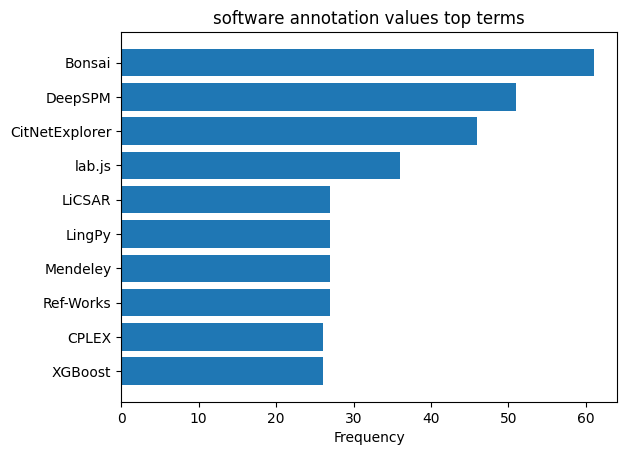

In [38]:
show_top_10("software")


Aggregating 1 elements
count: 245


/var/folders/mk/scd8428n18jfgh3jdthbvpz00000gn/T/ipykernel_6702/1087991225.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(keys)


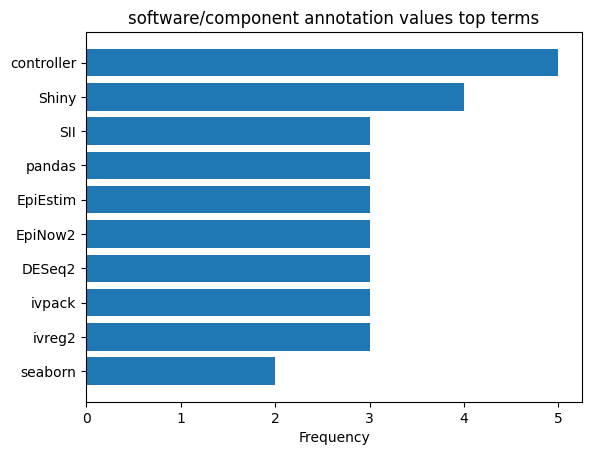

In [39]:
show_top_10("software/component")

Aggregating 6 elements
count: 270


/var/folders/mk/scd8428n18jfgh3jdthbvpz00000gn/T/ipykernel_6702/1087991225.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(keys)


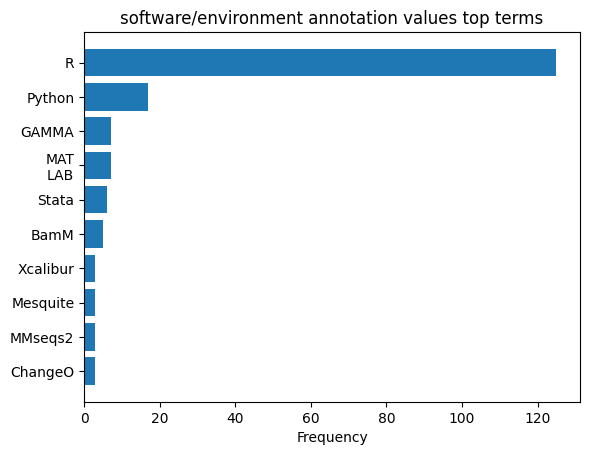

In [40]:
show_top_10("software/environment")

Aggregating 13 elements
count: 166


/var/folders/mk/scd8428n18jfgh3jdthbvpz00000gn/T/ipykernel_6702/1087991225.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(keys)


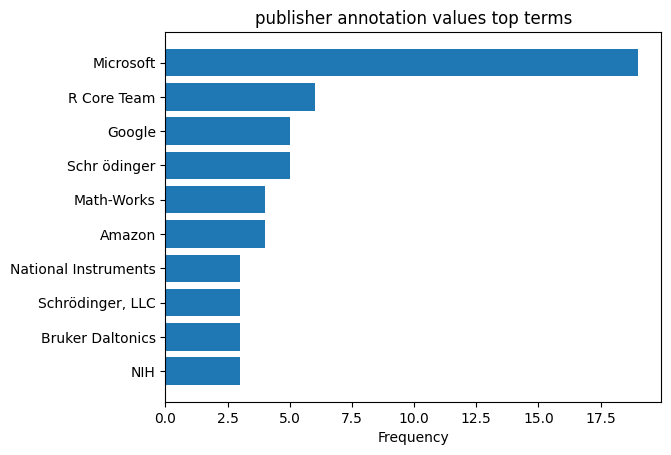

In [41]:
show_top_10("publisher")

Aggregating 0 elements
count: 12


/var/folders/mk/scd8428n18jfgh3jdthbvpz00000gn/T/ipykernel_6702/1087991225.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(keys)


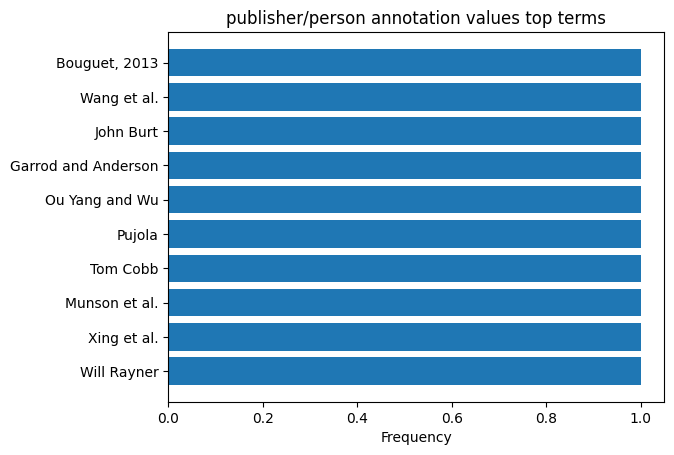

In [42]:
show_top_10("publisher/person")